In [13]:
# imports
import pandas as pd
import numpy as np
from pdpbox import pdp, info_plots
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import category_encoders as ce

In [14]:
# load in the dataset
df = pd.read_csv(r"..\data\iowa_train2.csv")

In [15]:
# fill in missing values
missing_cols_query   = df.isnull().sum() > 0
missing_cols_num     = df.loc[:, missing_cols_query].select_dtypes(include=np.number).columns.tolist()
missing_cols_cat     = df.loc[:, missing_cols_query].select_dtypes(include=np.object).columns.tolist()
df[missing_cols_num] = df[missing_cols_num].fillna(0)
df[missing_cols_cat] = df[missing_cols_cat].fillna('None')

In [16]:
# set up pipeline
ohe  = ce.OneHotEncoder(use_cat_names=True)
gbm  = GradientBoostingRegressor()

X    = ohe.fit_transform(df.drop('SalePrice', axis=1))
y    = df['SalePrice']

# create training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1985)

In [17]:
# fit the model
gbm.fit(X_train, y_train)

GradientBoostingRegressor()

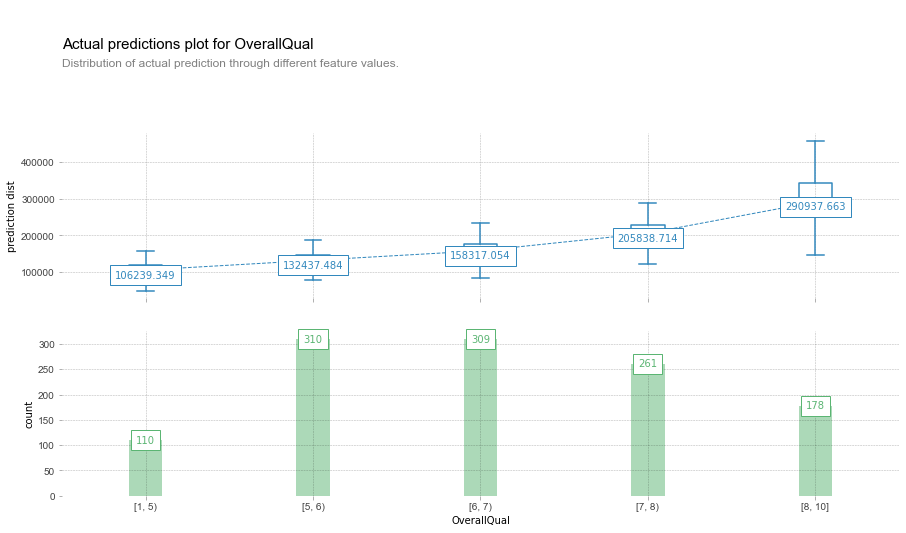

In [18]:
# what was the impact of overall quality on the housing price?
fig, axes, summary_df = info_plots.actual_plot(
    model=gbm, X=X_train, 
    feature='OverallQual', feature_name='OverallQual', predict_kwds={}
)

In [19]:
# chart is being created from this variable
summary_df

,x,display_column,value_lower,value_upper,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,"[1, 5)",1.0,5.0,110,90175.355338,106239.349316,119235.214426
1,1,"[5, 6)",5.0,6.0,310,118257.727445,132437.483954,145975.212142
2,2,"[6, 7)",6.0,7.0,309,138841.980698,158317.053666,177509.291164
3,3,"[7, 8)",7.0,8.0,261,185817.755062,205838.713855,227511.601122
4,4,"[8, 10]",8.0,10.0,178,255445.946209,290937.662987,340976.502194


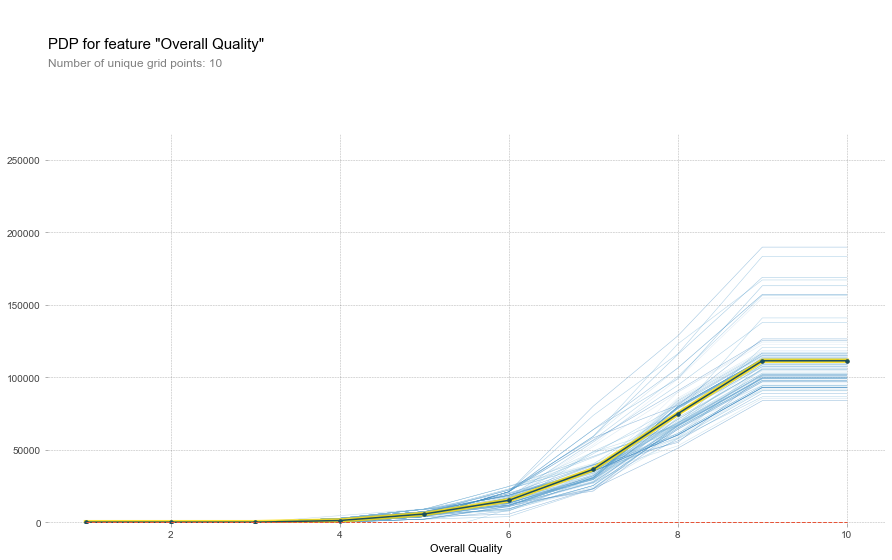

In [20]:
# what was the additive impact of EACH unique value of OverallQual?  What was its marginal impact?
pdp_overall_qual = pdp.pdp_isolate(
    model=gbm, dataset=X_train, model_features=X.columns.tolist(), 
    feature='OverallQual', cust_grid_points=X_train['OverallQual'].unique().tolist()
)
fig, axes = pdp.pdp_plot(pdp_overall_qual, 'Overall Quality', plot_lines=True, frac_to_plot=100)

In [21]:
# where do these values come from? -- average values if you changed OverallQual to each particular value
pdp_overall_qual.pdp

array([151329.94587309, 151329.94587309, 151329.94587309, 152507.25804487,
       156985.52748402, 166404.75409743, 187858.33158875, 226207.66439447,
       262736.88441002, 262736.88441002])

In [22]:
# a small example
# copy the dataframe
X_train_copy = X_train.copy()
# change the value of OverallQual to 10 for EVERY value
X_train_copy['OverallQual'] = 10
# and now look at what we have
X_train_copy['OverallQual']

461     10
373     10
1271    10
634     10
1245    10
        ..
446     10
1376    10
1078    10
709     10
1317    10
Name: OverallQual, Length: 1168, dtype: int64

In [23]:
# and now look at our predictions
preds = gbm.predict(X_train_copy)
# and note the average
preds.mean()

262736.8844100241

In [24]:
# and what about the lines?
pdp_overall_qual.ice_lines

,1,2,3,4,5,6,7,8,9,10
0,112252.345410,112252.345410,112252.345410,114928.353209,119517.324425,126679.461699,145181.532936,194118.690879,226955.961888,226955.961888
1,136390.898020,136390.898020,136390.898020,136390.898020,142712.945040,144444.564967,159251.506105,206050.021029,238887.292038,238887.292038
2,167853.228160,167853.228160,167853.228160,167853.228160,171704.137483,184533.558508,201707.057661,233925.039229,268632.960298,268632.960298
3,116588.879603,116588.879603,116588.879603,119264.887402,123853.858617,128557.431113,144584.507791,184282.746177,217120.017187,217120.017187
4,165207.587917,165207.587917,165207.587917,165207.587917,171529.634938,184734.410407,201866.654874,231761.418271,255416.393019,255416.393019
...,...,...,...,...,...,...,...,...,...,...
1163,184199.146023,184199.146023,184199.146023,184199.146023,188050.055346,205179.379855,240641.877486,274901.817749,309609.738818,309609.738818
1164,80262.913304,80262.913304,80262.913304,82938.921103,87527.892318,91718.077023,113268.564310,165877.386388,198714.657398,198714.657398
1165,132561.767084,132561.767084,132561.767084,132561.767084,137150.738300,144312.875574,160044.357048,199375.808053,232213.079062,232213.079062
1166,124633.410326,124633.410326,124633.410326,127309.418125,131898.389341,136088.574046,155164.066774,204344.276449,237181.547459,237181.547459


### And What About Neighborhoods?

In [25]:
# our column labels
ohe.get_feature_names()

['Id',
 'MSSubClass',
 'MSZoning_RL',
 'MSZoning_RM',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'LotArea',
 'Neighborhood_CollgCr',
 'Neighborhood_Veenker',
 'Neighborhood_Crawfor',
 'Neighborhood_NoRidge',
 'Neighborhood_Mitchel',
 'Neighborhood_Somerst',
 'Neighborhood_NWAmes',
 'Neighborhood_OldTown',
 'Neighborhood_BrkSide',
 'Neighborhood_Sawyer',
 'Neighborhood_NridgHt',
 'Neighborhood_NAmes',
 'Neighborhood_SawyerW',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Edwards',
 'Neighborhood_Timber',
 'Neighborhood_Gilbert',
 'Neighborhood_StoneBr',
 'Neighborhood_ClearCr',
 'Neighborhood_NPkVill',
 'Neighborhood_Blmngtn',
 'Neighborhood_BrDale',
 'Neighborhood_SWISU',
 'Neighborhood_Blueste',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'GrLivArea',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea.1',
 'FullBath',
 'HalfBath',
 'GarageType_Attchd',
 'GarageType_Detchd',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_None',
 'GarageType_Basment',
 'Ga

In [26]:
# first, let's grab neighborhood columns
neighborhood_cols = [col for col in ohe.get_feature_names() if 'Neighborhood' in col]
neighborhood_cols

['Neighborhood_CollgCr',
 'Neighborhood_Veenker',
 'Neighborhood_Crawfor',
 'Neighborhood_NoRidge',
 'Neighborhood_Mitchel',
 'Neighborhood_Somerst',
 'Neighborhood_NWAmes',
 'Neighborhood_OldTown',
 'Neighborhood_BrkSide',
 'Neighborhood_Sawyer',
 'Neighborhood_NridgHt',
 'Neighborhood_NAmes',
 'Neighborhood_SawyerW',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Edwards',
 'Neighborhood_Timber',
 'Neighborhood_Gilbert',
 'Neighborhood_StoneBr',
 'Neighborhood_ClearCr',
 'Neighborhood_NPkVill',
 'Neighborhood_Blmngtn',
 'Neighborhood_BrDale',
 'Neighborhood_SWISU',
 'Neighborhood_Blueste']

In [32]:
gbm.n_features_

55

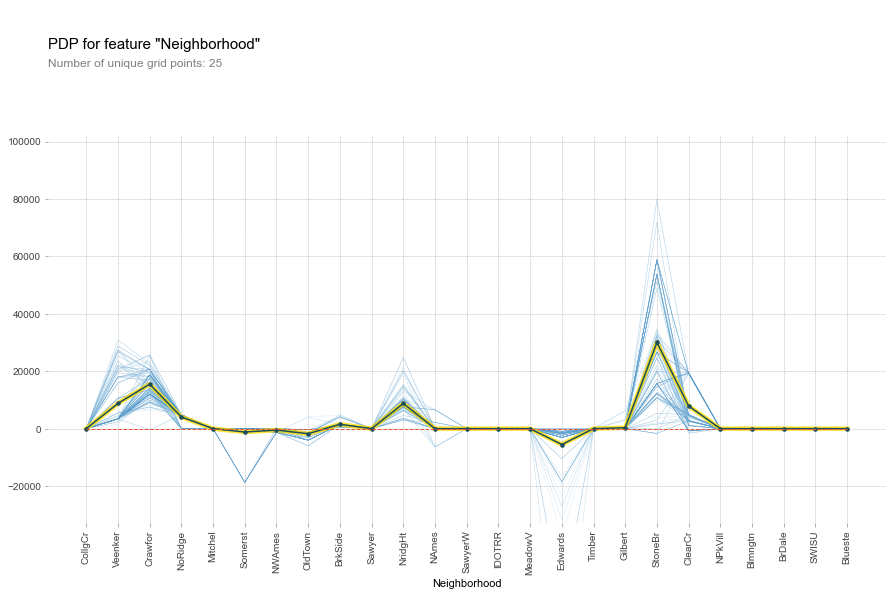

In [28]:
# and what about categorical variables?
# what was the impact of neighborhood on the housing price? 
pdp_neighborhood = pdp.pdp_isolate(
    model=gbm, dataset=X_train, model_features=X.columns.tolist(), 
    feature=neighborhood_cols
)
fig, axes = pdp.pdp_plot(pdp_neighborhood, 'Neighborhood', plot_lines=True, frac_to_plot=100)
# this code is just for formatting -- getting the labels to format correctly
xtick_labels = [label.split('_')[-1] for label in neighborhood_cols]
axes['pdp_ax'].set_xticklabels(xtick_labels, rotation='vertical');

In [ ]:
# and what about interactions?
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=gbm, X=X_train, 
    features=['OverallQual', neighborhood_cols], 
    feature_names=['Housing Quality', 'Neighborhood']
)

axes['value_ax'].set_yticklabels(xtick_labels);

In [ ]:
# and a slightly different look at the same problem
gbm_inter = pdp.pdp_interact(
    model=gbm, dataset=X_train, model_features=X_train.columns, 
    features=['OverallQual', 'GrLivArea']
)


fig, axes = pdp.pdp_interact_plot(
    gbm_inter, ['Overall Quality', 'LivingArea'], x_quantile=True, plot_type='grid', plot_pdp=True
)